



 # 二维Burgers方程的有限差分求解器

 本代码展示了neuralop库损失模块中的有限差分工具的使用， 并通过该工具实现一个简单的二维Burgers方程数值求解器。



In [7]:
# 导入PyTorch库，用于张量计算和设备管理（CPU/GPU）
import torch
# 导入NumPy库，用于数值数组运算和数学计算
import numpy as np
# 导入matplotlib的pyplot模块，用于绘制静态图形
import matplotlib.pyplot as plt
# 导入matplotlib的动画模块，用于生成动态可视化结果
import matplotlib.animation as animation
# 从neuralop的损失模块中导入有限差分工具类FiniteDiff
from neuralop.losses.differentiation import FiniteDiff

# 配置计算设备：优先使用可用的CUDA GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




 ## 定义求解问题

 本代码旨在求解二维粘性Burgers方程，该方程描述了粘性流体的流动特性，包含两个速度分量u和v，方程形式如下：



 \begin{align}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)\end{align}



 \begin{align}\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)\end{align}

 其中：

 - u、v：分别为x、y方向的流体速度分量

 - t：时间

 - x、y：空间坐标

 - ν：流体的粘性系数

 - 左侧：对流项（描述流体的输运特性）

 - 右侧：扩散项（描述流体的粘性扩散特性）



In [8]:
## 模拟参数配置
Lx, Ly = 2.0, 2.0  # 计算域的x、y方向长度（求解区域范围：0~Lx，0~Ly）
nx, ny = 64, 64  # x、y方向的网格分辨率（网格点数量）
T = 1  # 总模拟时间（从t=0到t=T）
dt = 0.001  # 时间步长（每次迭代推进的时间长度）
nu = 0.04  # 流体粘性系数（控制扩散项的强度，值越大扩散越明显）

## 创建二维计算网格
# 生成x方向的网格点，并通过repeat和转置构建二维x坐标张量（形状：nx×ny）
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T # 先补全为1*nx的新张量，第一维度重复ny次，第二维度重复1次
# 生成y方向的网格点，直接repeat构建二维y坐标张量（形状：nx×ny）
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)


具体来说，
$$
X= \left( \begin{array}{ccc}
    0 & \cdots & 0\\ 
    dx & \cdots & dx\\ 
    \vdots & \vdots &\vdots \\
    L_x=(n_x-1)dx & \cdots & Lx=(n_x-1)dx
\end{array} \right)_{n_x\times n_y},\quad 
Y= \left( \begin{array}{cccc}
    0 & dy & \cdots & Ly=(n_y-1)dy\\ 
    \vdots & \vdots& \vdots &\vdots \\
    0 & dy& \cdots & Ly=(n_y-1)dy
\end{array} \right)_{n_x\times n_y}
$$

In [9]:
# 计算x方向的网格步长（相邻网格点的间距）
dx = Lx / (nx - 1)
# 计算y方向的网格步长
dy = Ly / (ny - 1)
# 计算总时间步数（总模拟时间 / 时间步长，取整得到迭代次数）
nt = int(T / dt)

## 初始化有限差分算子
# 实例化2维有限差分对象，传入网格步长(h)，用于后续计算空间导数
fd = FiniteDiff(dim=2, h=(dx, dy))

## 设置初始条件（t=0时刻的u和v速度分布）
# u的初始值：基于y坐标的正弦函数，移至指定计算设备
u = -torch.sin(2 * np.pi * Y).to(device)
# v的初始值：基于x坐标的余弦函数，移至指定计算设备
v = torch.cos(2 * np.pi * X).to(device)




 ## 利用数值求解器模拟方程演化过程

 采用有限差分法离散空间导数，欧拉法推进时间演化，逐步求解每个时间步的u和v值。


In [10]:
# 初始化列表，用于保存每个时间步的u和v结果（便于后续可视化和分析）
# 先存入初始时刻（t=0）的u值，使用clone()防止后续修改影响历史数据
u_evolution = [u.clone()]
# 存入初始时刻（t=0）的v值
v_evolution = [v.clone()]

# 循环迭代，推进时间演化（共nt步，对应从t=0到t=T）
for _ in range(nt):
    # 计算一阶空间导数（利用有限差分算子fd求解偏导数）
    u_x = fd.dx(u)  # u对x的一阶偏导数 ∂u/∂x
    u_y = fd.dy(u)  # u对y的一阶偏导数 ∂u/∂y
    v_x = fd.dx(v)  # v对x的一阶偏导数 ∂v/∂x
    v_y = fd.dy(v)  # v对y的一阶偏导数 ∂v/∂y

    # 计算二阶空间导数（对一阶导数再次求导得到二阶导数）
    u_xx = fd.dx(u_x)  # u对x的二阶偏导数 ∂²u/∂x²
    u_yy = fd.dy(u_y)  # u对y的二阶偏导数 ∂²u/∂y²
    v_xx = fd.dx(v_x)  # v对x的二阶偏导数 ∂²v/∂x²
    v_yy = fd.dy(v_y)  # v对y的二阶偏导数 ∂²v/∂y²

    # 采用欧拉方法（前向欧拉）推进时间，求解下一个时间步的u和v
    # 代入二维Burgers方程的离散形式，计算t+dt时刻的u值
    u_next = u + dt * (-u * u_x - v * u_y + nu * (u_xx + u_yy))
    # 代入二维Burgers方程的离散形式，计算t+dt时刻的v值
    v_next = v + dt * (-u * v_x - v * v_y + nu * (v_xx + v_yy))

    # 更新当前时间步的u和v，为下一次迭代做准备（clone()防止张量共享内存）
    u, v = u_next.clone(), v_next.clone()
    # 将当前时间步的u存入演化列表，保存历史数据
    u_evolution.append(u.clone())
    # 将当前时间步的v存入演化列表，保存历史数据
    v_evolution.append(v.clone())

# 将保存的所有时间步的u和v张量转换为NumPy数组（移至CPU，方便matplotlib绘图）
u_evolution = torch.stack(u_evolution).cpu().numpy()
v_evolution = torch.stack(v_evolution).cpu().numpy()




 ## 生成结果动画，可视化演化过程

 由于总时间步较多，抽取部分关键帧生成动画，更清晰地展示u和v的时空演化特性。



2D动画已保存至当前目录：2d_burgers_u_v_evolution.gif


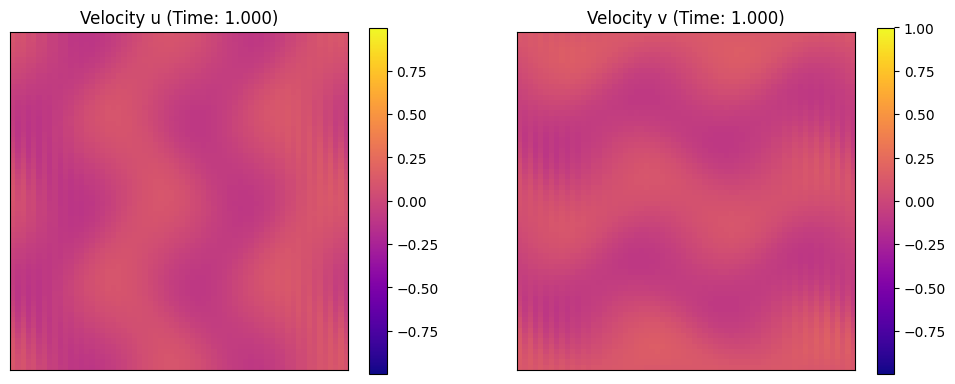

In [15]:
# 设置动画的总帧数（抽取100帧进行可视化，避免动画过于冗长）
num_frames = 100
# 从所有时间步中均匀抽取num_frames个帧的索引（保证时间分布均匀）
frame_indices = (
    torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
)
# 根据抽取的索引，获取对应的u和v帧数据（用于动画生成）
u_frames = u_evolution[frame_indices]
v_frames = v_evolution[frame_indices]

# 创建绘图窗口和子图（1行2列，展示u和v的动画对比，设置图窗大小）
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# 初始化u的热力图（展示第一帧数据，设置坐标范围、原点位置和颜色映射）
cmap_u = axs[0].imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
# 设置第一个子图的标题
axs[0].set_title("Velocity u")
# 为u的热力图添加颜色条（缩小小幅，适配子图布局）
plt.colorbar(cmap_u, ax=axs[0], shrink=0.75) 
# 初始化v的热力图（展示第一帧数据，设置坐标范围、原点位置和颜色映射）
cmap_v = axs[1].imshow(v_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
# 设置第二个子图的标题
axs[1].set_title("Velocity v")
# 为v的热力图添加颜色条（缩小小幅，适配子图布局）
plt.colorbar(cmap_v, ax=axs[1], shrink=0.75)

# 定义动画更新函数：每帧更新热力图数据和标题
def update(frame):
    # 更新u热力图的数据源（当前帧的u数据）
    cmap_u.set_data(u_frames[frame])
    # 更新v热力图的数据源（当前帧的v数据）
    cmap_v.set_data(v_frames[frame])
    # 更新u子图的标题，显示当前对应的模拟时间（保留3位小数）
    axs[0].set_title(f"Velocity u (Time: {frame_indices[frame] * dt:.3f})")
    # 更新v子图的标题，显示当前对应的模拟时间（保留3位小数）
    axs[1].set_title(f"Velocity v (Time: {frame_indices[frame] * dt:.3f})")
    # 隐藏u子图的x轴刻度，使图像更整洁
    axs[0].set_xticks([])
    # 隐藏u子图的y轴刻度，使图像更整洁
    axs[0].set_yticks([])
    # 隐藏v子图的x轴刻度，使图像更整洁
    axs[1].set_xticks([])
    # 隐藏v子图的y轴刻度，使图像更整洁
    axs[1].set_yticks([])
    # 返回更新后的热力图对象，用于动画渲染
    return cmap_u, cmap_v

# 创建FuncAnimation动画对象，生成最终动画
# 参数说明：fig-绘图窗口，update-帧更新函数，frames-总帧数，interval-帧间隔时间（毫秒），blit-是否只更新变化区域
ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
# 创建FuncAnimation动画对象，生成最终动画
ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)

# ===================== 保存2D动画为GIF格式（无额外依赖） =====================
# 直接保存为GIF，无需配置任何编码器，文件名：2d_burgers_u_v_evolution.gif
ani.save("2d_burgers_u_v_evolution.gif", writer='pillow', fps=20)
# 说明：writer='pillow' 是matplotlib内置的GIF编码器，依赖Pillow库（一般已随matplotlib安装）
print("2D动画已保存至当前目录：2d_burgers_u_v_evolution.gif")
# ==============================================================================

plt.show()

## 三维空间可视化数值解
将x、y作为平面二维坐标，速度分量u（或v）作为z轴高度，构建3D表面图，
更直观地展示速度场的空间分布和时间演化特性。


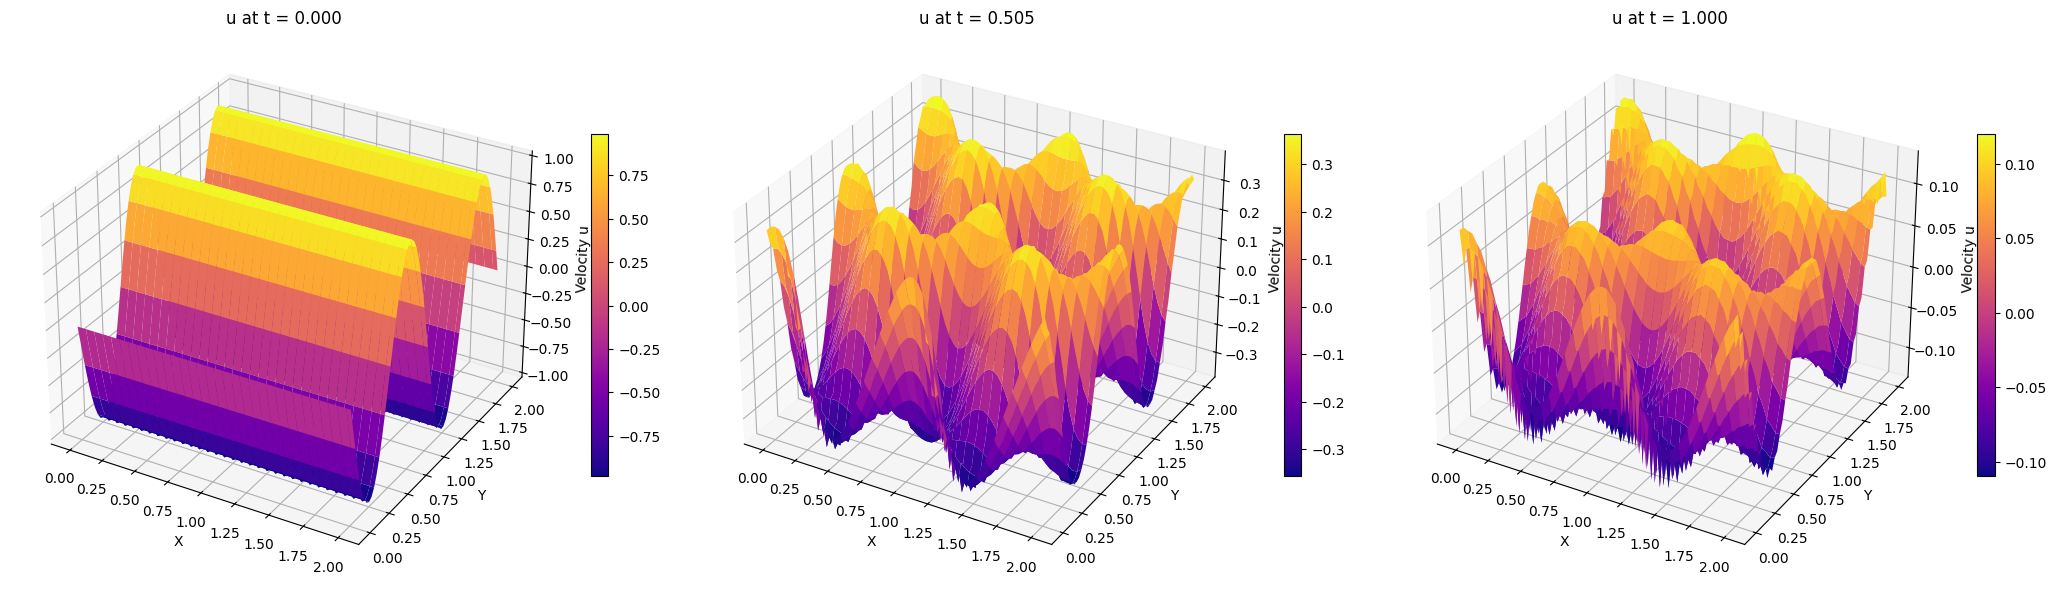

In [ ]:
# 导入matplotlib的3D绘图工具包，用于创建3D坐标轴
from mpl_toolkits.mplot3d import Axes3D

# 第一步：重构3D绘图所需的规整网格（基于原有的计算域参数）
x = np.linspace(0, Lx, nx)  # x方向网格点（numpy数组，用于3D绘图）
y = np.linspace(0, Ly, ny)  # y方向网格点（numpy数组，用于3D绘图）
X_3d, Y_3d = np.meshgrid(x, y)  # 生成3D绘图所需的二维网格矩阵（形状：ny×nx）

# ---------------------- 1. 静态3D图：展示关键时间点的u分布 ----------------------
# 选取3个关键时间点：初始时刻（t=0）、中间时刻（t=0.5）、最终时刻（t=1.0）
key_time_indices = [0, int(num_frames/2), num_frames-1]
# 创建3D绘图窗口（1行3列，设置图窗大小）
fig_3d_static, axs_3d_static = plt.subplots(1, 3, figsize=(21, 6), subplot_kw=dict(projection='3d'))

for idx, time_idx in enumerate(key_time_indices):
    # 获取当前时间点的u数据（注意转置，匹配X_3d、Y_3d的形状）
    u_data = u_frames[time_idx].T
    # 绘制3D表面图
    surf = axs_3d_static[idx].plot_surface(
        X_3d, Y_3d, u_data,
        cmap='plasma',  # 颜色映射（与2D图保持一致）
        linewidth=0,    # 隐藏表面网格线，使图像更整洁
        antialiased=True  # 抗锯齿，提升图像清晰度
    )
    # 设置3D坐标轴标签
    axs_3d_static[idx].set_xlabel('X')
    axs_3d_static[idx].set_ylabel('Y')
    axs_3d_static[idx].set_zlabel('Velocity u')
    # 计算当前对应的模拟时间
    current_time = frame_indices[time_idx] * dt
    # 设置子图标题
    axs_3d_static[idx].set_title(f'u at t = {current_time:.3f}')
    # 添加颜色条（适配3D子图）
    fig_3d_static.colorbar(surf, ax=axs_3d_static[idx], shrink=0.6)

# 调整子图间距，避免重叠
plt.tight_layout()
plt.show()

c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


3D动画已保存至当前目录：3d_burgers_u_evolution.gif


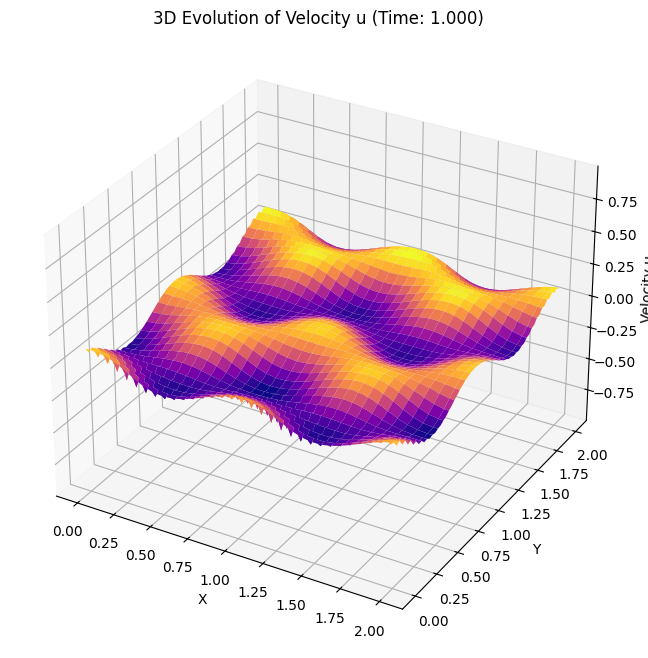

In [16]:
# ---------------------- 2. 3D动画：展示u随时间演化的动态过程 ----------------------
# 创建3D绘图窗口
fig_3d_ani = plt.figure(figsize=(10, 8))
ax_3d_ani = fig_3d_ani.add_subplot(111, projection='3d')

# 初始化3D表面图（第一帧数据）
u_initial = u_frames[0].T
surf_3d = ax_3d_ani.plot_surface(
    X_3d, Y_3d, u_initial,
    cmap='plasma',
    linewidth=0,
    antialiased=True
)
# 设置固定的坐标轴标签和范围（避免动画过程中坐标轴抖动）
ax_3d_ani.set_xlabel('X')
ax_3d_ani.set_ylabel('Y')
ax_3d_ani.set_zlabel('Velocity u')
# 计算u的全局最大值和最小值，固定z轴范围
u_min = u_frames.min()
u_max = u_frames.max()
ax_3d_ani.set_zlim(u_min, u_max)

# 定义3D动画的更新函数
def update_3d(frame):
    # 清除上一帧的表面图（避免重叠）
    global surf_3d
    surf_3d.remove()
    # 获取当前帧的u数据（转置匹配网格形状）
    u_current = u_frames[frame].T
    # 绘制当前帧的3D表面图
    surf_3d = ax_3d_ani.plot_surface(
        X_3d, Y_3d, u_current,
        cmap='plasma',
        linewidth=0,
        antialiased=True
    )
    # 更新标题，显示当前模拟时间
    current_time = frame_indices[frame] * dt
    ax_3d_ani.set_title(f'3D Evolution of Velocity u (Time: {current_time:.3f})')
    return surf_3d,

# 创建3D动画对象
ani_3d = animation.FuncAnimation(
    fig_3d_ani,
    update_3d,
    frames=len(u_frames),
    interval=50,
    blit=False
)
# 创建3D动画对象
ani_3d = animation.FuncAnimation(
    fig_3d_ani,
    update_3d,
    frames=len(u_frames),
    interval=50,
    blit=False
)

# ===================== 保存3D动画为GIF格式（无额外依赖） =====================
ani_3d.save("3d_burgers_u_evolution.gif", writer='pillow', fps=20)
print("3D动画已保存至当前目录：3d_burgers_u_evolution.gif")
# ==============================================================================

plt.show()
